# Vision and Language Understanding

V&L encoder models can process language and visual modalities in different ways. Depending on their attention architectures the models will be able to address different tasks with different performance and number of parameters. The three encoder architectures are:
 - One encoder per modality
 - Multimodal cross-encoder
 - Co-attention encoder

# CLIP: Contrastive Language-Image Pre-training

*Radford, Alec, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal, Girish Sastry et al. "Learning transferable visual models from natural language supervision." In International conference on machine learning, pp. 8748-8763. PMLR, 2021. https://arxiv.org/abs/2103.00020*

The CLIP model uses one encoder for each modality that are jointly trained with a contrastive Language-Image loss. Each encoder will learn how to project its single-modality input into a cross-modal space where vectors are organized according to their cross-modal similarity, e.g. a text caption describing two cats should be close to an image with two cats.

The HuggingFace model documentation is available here: https://huggingface.co/docs/transformers/model_doc/clip

To load the model and its input processor you can do the following:

In [6]:
from PIL import Image
import requests
import torch

from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel

device = "cuda:0" if torch.cuda.is_available() else "cpu"

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

The CLIP model is composed by a text model and a vision model. The text model has an embedding layer (embeddings), 12 encoder layers (encoder) and one final normalization layer (final_layer_norm). The vision model has a similar architecture with some extra layers: it has an embedding layer (embeddings), a pre-normalization layer, 12 encoder layers (encoder) and one final normalization layer (post_layernorm).

Both models are then followed by a text projection layer and a vision projection layer.

In [7]:
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

## Multimodal input preparation
CLIP model requires processing the input image and the corresponding sentence/text. In our case we are loading an image with 640x480 pixels and two sentences.
The processor method pre-processes the inputs:

 - The input sentences are tokenized and stored as text tokens (input_ids).
 - The input image is resized and cropped to 224x224 pixes

 These representations will then be fed the embedding layers.

In [8]:
import requests

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/1200px-Cat_November_2010-1a.jpg'
save_path = "cat_example.jpg"

response = requests.get(url)

with open(save_path, 'wb') as file:
    file.write(response.content)

In [10]:
import os

file_path = "cat_example.jpg"
if os.path.exists(file_path):
    print(f"File size: {os.path.getsize(file_path)} bytes")
    # Peek at the first few characters to see if it's actually an HTML error page
    with open(file_path, 'rb') as f:
        print(f"Start of file: {f.read(20)}")

File size: 126 bytes
Start of file: b'Please set a user-ag'


In [12]:
import requests

url = "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg"

# Adicionamos um User-Agent para o site não nos bloquear
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    with open("cat_example.jpg", 'wb') as f:
        f.write(response.content)
    print("Download concluído com sucesso!")
else:
    print(f"Erro no download. Status code: {response.status_code}")

Download concluído com sucesso!


In [13]:
url_cat = "cat_example.jpg"
image = Image.open(url_cat)
inputs = processor(text=["a photo of a bird", "a photo of cat"],
                        images=image,
                        return_tensors="pt",
                        padding=True).to(device)
image.size

(1600, 1598)

In [14]:
inputs.keys()

KeysView({'pixel_values': tensor([[[[1.3756, 1.4340, 1.4632,  ..., 1.5800, 1.5946, 1.5946],
          [1.3756, 1.4340, 1.4778,  ..., 1.5946, 1.6238, 1.6238],
          [1.3756, 1.4194, 1.4632,  ..., 1.6530, 1.6530, 1.6530],
          ...,
          [0.9522, 0.9960, 0.9522,  ..., 1.4194, 1.4048, 1.3902],
          [0.9522, 0.9960, 0.9522,  ..., 1.4486, 1.4632, 1.4486],
          [0.9230, 0.9376, 0.9376,  ..., 1.4632, 1.4778, 1.4924]],

         [[1.3695, 1.4295, 1.4746,  ..., 1.6096, 1.5796, 1.5796],
          [1.3695, 1.4295, 1.4896,  ..., 1.6247, 1.6096, 1.5796],
          [1.3995, 1.4295, 1.5046,  ..., 1.6096, 1.5796, 1.5196],
          ...,
          [0.6041, 0.6491, 0.5891,  ..., 1.3395, 1.3545, 1.3545],
          [0.6341, 0.6642, 0.6041,  ..., 1.3995, 1.3995, 1.3995],
          [0.5591, 0.6041, 0.5891,  ..., 1.4145, 1.4295, 1.4446]],

         [[1.0367, 1.0936, 1.2074,  ..., 1.5060, 1.5060, 1.5060],
          [1.0083, 1.0936, 1.2074,  ..., 1.5487, 1.5202, 1.5060],
          [0.979

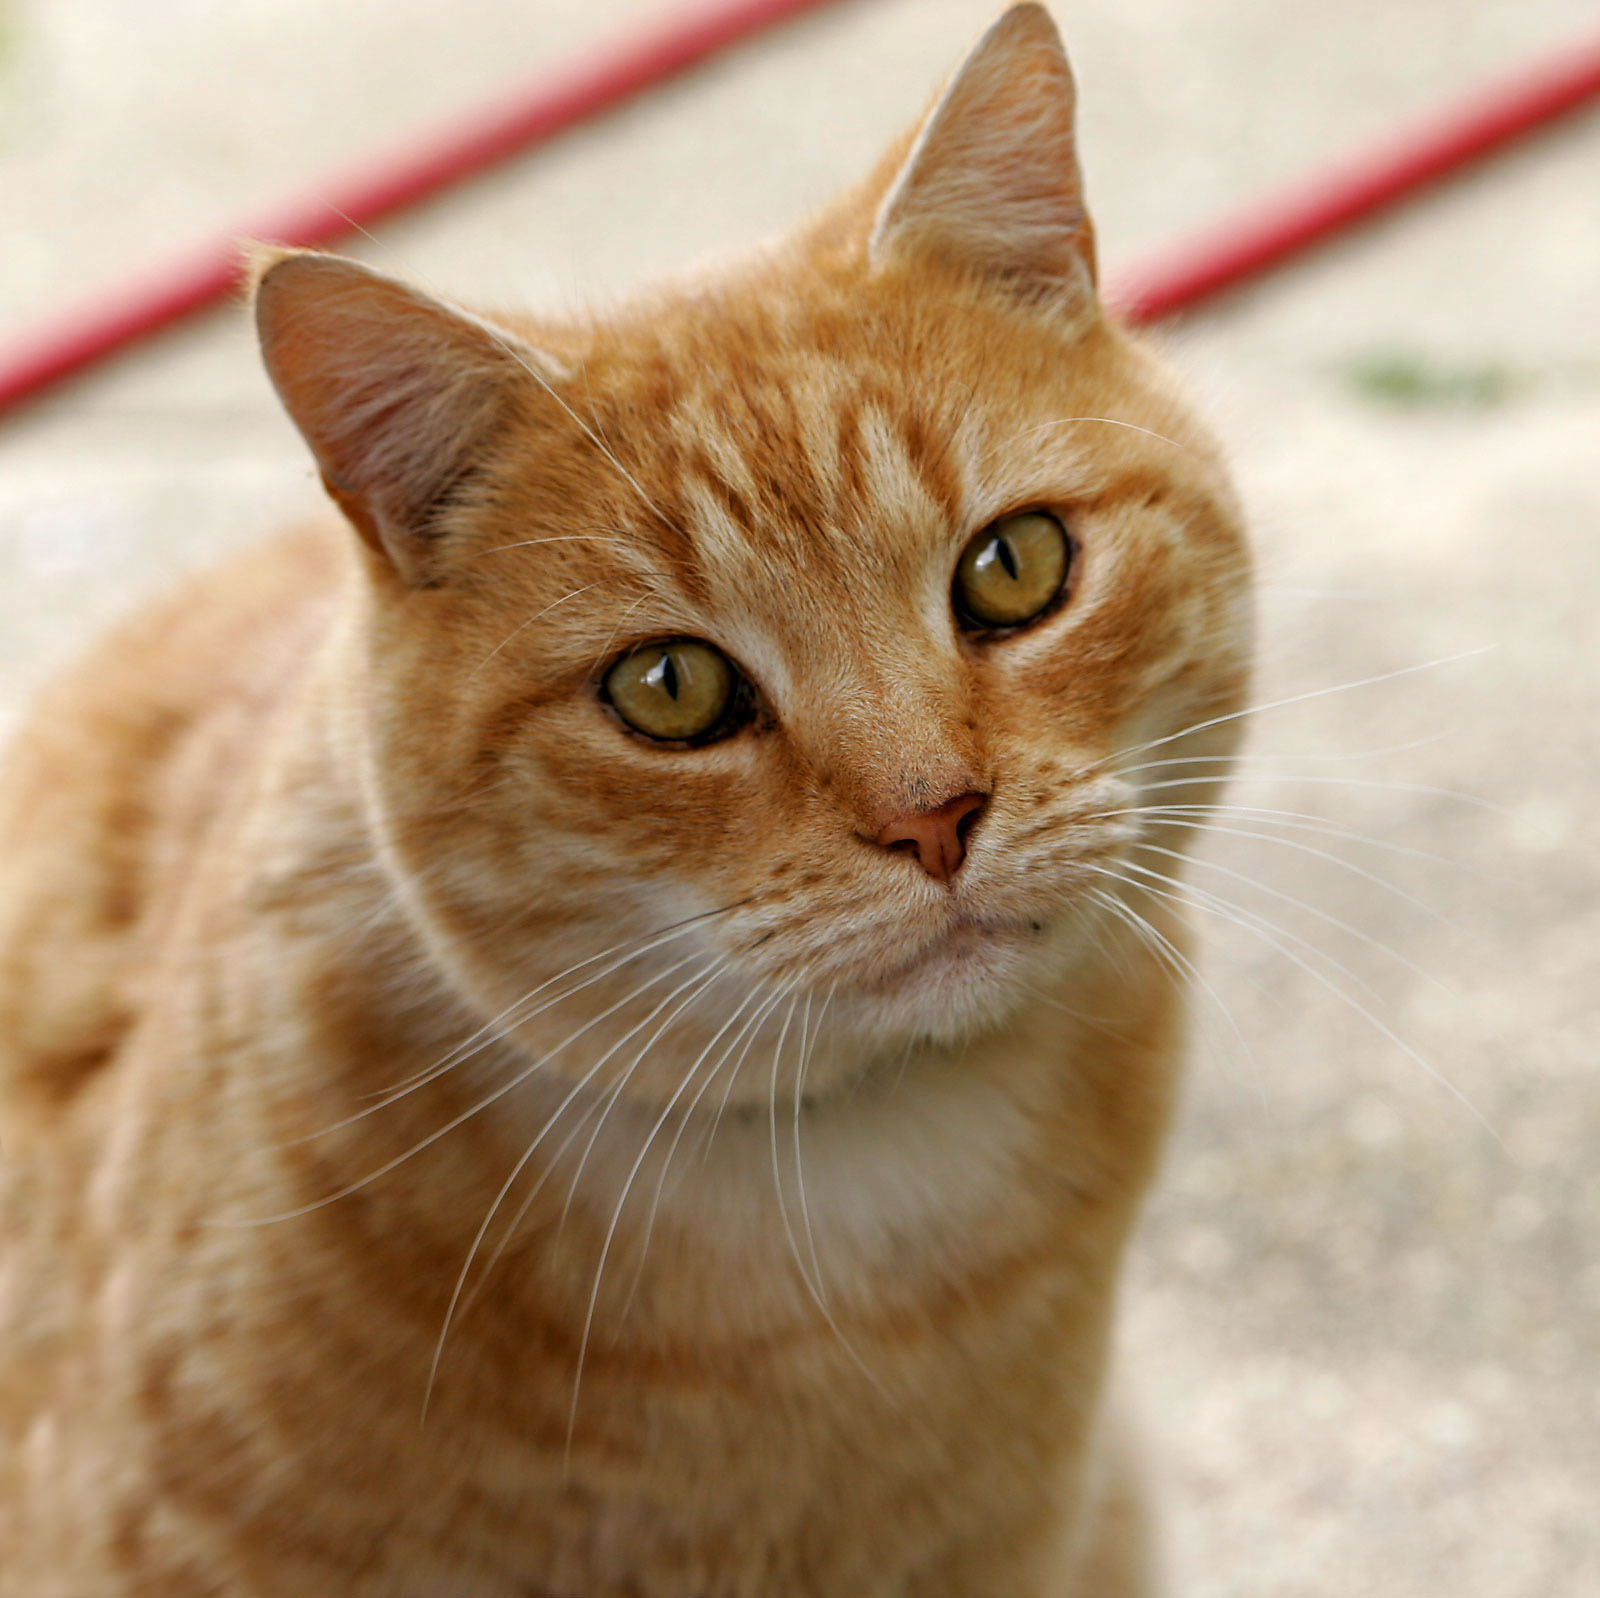

In [15]:
from IPython.display import Image
Image(url_cat)

## Text Encoder Model

In [ ]:
model.text_model

### Tokenizer

### Exercise: Tokenize a custom sentence

Modify the sentence below and run the tokenizer to inspect input_ids shape.

In [ ]:
# TODO: Change the text and run the tokenizer
text = "a photo of a cat"
inputs = None
print(inputs['input_ids'].shape)

In [ ]:
inputs['input_ids']

In [ ]:
print(processor.tokenizer.decode(inputs["input_ids"][0].tolist()))

### Encoder layers and Output token

In [ ]:
output = model.text_model(inputs["input_ids"], output_hidden_states = True)

### Exercise: Normalize image embeddings

Add L2 normalization to the image embeddings.

In [ ]:
# TODO: Add normalization
image_embeds = None
print(image_embeds.norm(dim=-1))

In [ ]:
output.keys()

## Vision Encoder Model

The CLIP vision encoder is composed of an embedding layer (embeddings), a pre normalization layer (pre_layrnorm), 12 Transformer encoder layers (encoder), and a final normalization layer (post_layernorm).

In [ ]:
model.vision_model

### Embedding layer
The vision encoder receives as input an image in an RGB matrix format. Note that the original image was resized to 224x224 pixels shape to align it with the convolution configuration of the model:

In [ ]:
inputs['pixel_values'].squeeze().size()

The initial layer of the CLIP encoder uses a 2D convolution layer with a 32x32 kernels and 32x32 strides. Since the input image is 224x224 pixels, it will generate 7x7 image patches and its corresponding embeddings. If we add the [CLS] token, we end up with 50 input embeddings.

In [ ]:
output = model.vision_model(inputs['pixel_values'], output_hidden_states = True)

In [ ]:
output.keys()

In [ ]:
output.hidden_states[0].size()

### Encoder layers and Output token

The different encoder layers will leverage the self-attention mechanism to iteratively compute the visual embeddings. The final layer will produce the output [CLS] token.

In [ ]:
output.last_hidden_state.size()

In [ ]:
output.pooler_output.size()

## CLIP Score

In [ ]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
probs

## Cross-modal retrieval

### Text feature extraction
Using CLIP text model provides you access to a number of inner information that is usefull to a number of tasks. However, if you only want the output embeddings, then you can use the simpler method get_text_features():

In [ ]:
inputs = processor(text=["a photo of a bird", "a photo of cat"],
                        return_tensors="pt",
                        padding=True).to(device)

text_embeddings = model.get_text_features(**inputs)
text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)


In [ ]:
# The output text embedding is a 512 dimensional vector
text_embeddings.size()

### Exercise: Compute CLIP similarity manually

Compute cosine similarity between text and image features.

In [ ]:
# TODO: Add cosine similarity
sim = None
print(sim)

### Image feature extraction
Using CLIP text model provides you access to a number of inner information that is usefull to a number of tasks. However, if you only want the output embeddings, then you can use the simpler method get_text_features():

In [ ]:
inputs = processor(images=image, return_tensors="pt").to(device)
image_embeddings = model.get_image_features(**inputs)
image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)


In [ ]:
# The output image embedding is a 512 dimensional vector
image_embeddings.size()

### CLIP Score
CLIP score is computed as the inner product between the two vectors (note that because we normalized the vectors previously, this is equivalent to the cosine distance):

In [ ]:
image_embeddings @ text_embeddings.T

# SigLIP: Sigmoid Loss for Language-Image Pre-training

*Zhai, Xiaohua, et al. "Sigmoid loss for language image pre-training." Proceedings of the IEEE/CVF International Conference on Computer Vision. 2023.*

The SigLIP model builds upon CLIP by replacing the contrastive Language-Image loss with a pairwise sigmoid loss. This modification allows the model to compute losses independently for each image-text pair, improving computational efficiency while maintaining alignment in the shared cross-modal space. Each encoder projects its single-modality input into this space, where vectors are organized by cross-modal similarity, e.g., a text caption describing two cats aligns closely with an image of two cats.

The HuggingFace model documentation is available here: https://huggingface.co/google/siglip-so400m-patch14-384

Before we begin, you'll need to install these:

In [ ]:
%pip install protobuf
%pip install sentencepiece

In [ ]:
from transformers import AutoProcessor, AutoModel
import torch

model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384")
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")

In [ ]:
from PIL import Image
import requests
from IPython.display import display

#url = "http://images.cocodataset.org/val2017/000000039769.jpg"
url = "https://www.animalfriends.co.uk/siteassets/media/images/article-images/cat-articles/50_afi_article1_a-guide-to-introducing-two-cats.png"
image = Image.open(requests.get(url, stream=True).raw)
display(image)
image = image.convert("RGB")

#### Zero-shot capabilities
SigLIP can also generalize incredibly well without requiring fine-tuning! For example, given an image and a set of textual descriptions, SigLIP computes similarity scores for each description and identifies the most relevant one. See for yourself!

In [ ]:
texts = ["a photo of 2 cats", "a photo of 2 dogs"]
inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image)  #these are the probabilities
print(f"{probs[0][0]:.1%} that image 0 is '{texts[0]}'")

In [ ]:
url1 = 'https://www.petfinder.com/sites/default/files/images/content/100691619-what-is-cat-fostering-632x475.jpg'
url2 = 'https://static.vecteezy.com/system/resources/thumbnails/005/857/332/small_2x/funny-portrait-of-cute-corgi-dog-outdoors-free-photo.jpg'
image1 = Image.open(requests.get(url1, stream=True).raw)
image2 = Image.open(requests.get(url2, stream=True).raw)
display(image1)
display(image2)

text_descriptions = ["a photo of a cat", "a photo of a dog", "a photo of a bicycle"]

inputs1 = processor(text=text_descriptions, images=image1, padding="max_length", return_tensors="pt")
inputs2 = processor(text=text_descriptions, images=image2, padding="max_length", return_tensors="pt")


with torch.no_grad():
    outputs1 = model(**inputs1)
    outputs2 = model(**inputs2)
    logits_per_image1 = outputs1.logits_per_image
    logits_per_image2 = outputs2.logits_per_image

    probs1 = torch.sigmoid(logits_per_image1)
    probs2 = torch.sigmoid(logits_per_image2)


print("Image 1 Similarity Scores:")
for text, score in zip(text_descriptions, probs1[0]):
    print(f"{text}: {score:.1%}")

print("Image 2 Similarity Scores:")
for text, score in zip(text_descriptions, probs2[0]):
    print(f"{text}: {score:.1%}")


You can see that the architecture is basically the same as CLIP! Try to see the specific architectures of the text and vision encoder and compare them too!

In [ ]:
model

What if we compare both models? A true clash of titans!

In [ ]:
from PIL import Image
import requests
from IPython.display import display

url = "https://images.pexels.com/photos/4498135/pexels-photo-4498135.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
display(image)

candidate_labels = ['A photo of a box', 'A photo of a house', 'A photo of a dog', 'A photo of a car']

In [ ]:
from transformers import pipeline

siglip_classifier = pipeline(task="zero-shot-image-classification", model="google/siglip-so400m-patch14-384")
clip_classifier = pipeline(task="zero-shot-image-classification", model="openai/clip-vit-base-patch32")


print("SigLIP Predictions:")
siglip_outputs = siglip_classifier(image, candidate_labels=candidate_labels)
print(siglip_outputs)

print("CLIP Predictions:")
clip_outputs = clip_classifier(image, candidate_labels=candidate_labels)
print(clip_outputs)


# VILT: Vision-and-language transformer

*Kim, Wonjae, Bokyung Son, and Ildoo Kim. "Vilt: Vision-and-language transformer without convolution or region supervision." In International Conference on Machine Learning, pp. 5583-5594. PMLR, 2021. https://arxiv.org/pdf/2102.03334.pdf*

The HuggingFace model documentation is available here: https://huggingface.co/docs/transformers/model_doc/vilt


In [ ]:
from transformers import ViltProcessor, ViltForQuestionAnswering, AutoTokenizer, AutoConfig

model_path = "dandelin/vilt-b32-finetuned-vqa"

config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)
processor = ViltProcessor.from_pretrained(model_path)
model = ViltForQuestionAnswering.from_pretrained(model_path, config=config)

In [ ]:
model

## Prepare the input

In [ ]:
import requests

url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSfsWqSoxDn4uV6yua97W1IievpLE5aif9D2g&s'
save_path = "cow_example.jpg"

response = requests.get(url)

with open(save_path, 'wb') as file:
    file.write(response.content)

In [ ]:
from PIL import Image
# prepare image + question
url_cow = 'cow_example.jpg'
image = Image.open(url_cow)
question = "Which animal is this?"

In [ ]:
# prepare inputs
VQ_encoding = processor(image, question, return_tensors="pt")
VQ_encoding.keys()

In [ ]:
VQ_encoding['input_ids']

In [ ]:
processor.tokenizer.convert_ids_to_tokens(VQ_encoding["input_ids"][0])

### Exercise: Change candidate answers

Add one more answer to the candidate list and rerun inference.

In [ ]:
# TODO: Add a new answer option


In [ ]:
print(processor.tokenizer.decode(VQ_encoding["input_ids"][0].tolist()))

In [ ]:
from IPython.display import Image
_c, _h, _w = VQ_encoding.data['pixel_values'].squeeze().size()
print("Image was resized to ", _w, _h, )
Image(url_cow, width = _w, height = _h)

Let's analyze how the text and image components are tokenized and structured in the input sequence for CLIP!

In [ ]:
_c, _h, _w = VQ_encoding.data['pixel_values'].squeeze().size() #channels, heigh and width
H = int(_h/32)
W = int(_w/32)
img_first_patch = len(VQ_encoding.tokens()) #retrieves the total number of tokens (text + image patches) in the input sequence after tokenization

print("The input sequence is: [CLS] tk1 tk2 .... tkn [SEP] vk1 vk2 ... vkm [SEP]\n")
print("The total number of text tokens are ", img_first_patch-2, ", including special tokens are", img_first_patch)

print("The token that separates text from the first image patch is the special token ",
      processor.decode(VQ_encoding.input_ids[0][img_first_patch-1], skip_special_tokens=False)) #identifying the [SEP] token
print()
print("The first image patch is in position ", img_first_patch)
print("The image patches are 32x32 pixels, totaling ", H , "x" , W , " = ", H*W, "image patches\n")
print("The input sequence length is: 1 + ", img_first_patch-2, " + 1 +", H*W , " + 1", " = ", img_first_patch + H*W + 1)


In [ ]:
VQ_encoding.data['pixel_values'].size()

## Set of possible answers

In [ ]:
for i in range(10):
    print(model.config.id2label[i])

## Run the inference step

In [ ]:
# forward pass
outputs = model(**VQ_encoding, return_dict = True)
logits = outputs.logits
idx = logits.argmax(-1).item()

In [ ]:
outputs.hidden_states[0].size()

In [ ]:
print(question)
print("Predicted answer:", model.config.id2label[idx])
from IPython.display import Image
Image(url_cow, width = _w, height = _h)

## Inspect the model computations

In [ ]:
layer = 2
layer_last = 12
head = 1
token = 3
outputs.keys()

In [ ]:
# Attentions
outputs.attentions[layer][0][head].shape

In [ ]:
# Contextual embeddings
outputs.hidden_states[layer][0].shape

In [ ]:
text_embeddings = outputs['hidden_states'][layer_last][0][0:img_first_patch]
img_patches_embeddings = outputs['hidden_states'][layer_last][0][img_first_patch:-1]

print("The output embeddings matrix for the text tokens are   [#text tokens, dim_tokens] ", text_embeddings.size())
print("The output embeddings matrix for the visual tokens are [#visual tokens, dim_tokens] ", img_patches_embeddings.size())